# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
import torch


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(
    family=pv.BicopFamily.joe,
    parameters=np.array([[2.5]]), rotation=90
    )


#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.clayton,
#    parameters=np.array([[2.0]]), rotation=0
#    )

#rho_t =0.7
#nu_t = 4.0
#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.student,
#    parameters=np.array([[rho_t],
#                          [nu_t]]),
#    rotation=0
#)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_16077/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_16077/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_16077/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_tes

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2026-01-05 15:50:08,662] A new study created in RDB with name: no-name-69c3d5de-57bb-4a5c-8b93-ec4814f364e7
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.4522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4482, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:05<1:10:14,  2.11s/it]

current_loss_val:  1.4438488483428955
current_loss: tensor(1.4482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4360651969909668
current_loss: tensor(1.4400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:05<26:10,  1.27it/s]  

current_loss_val:  1.41024911403656
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.410552978515625
current_loss: tensor(1.4190, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:05<13:01,  2.55it/s]

current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4103142023086548
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4094274044036865
current_loss: tensor(1.4184, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:05<09:54,  3.36it/s]

current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.409134864807129
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:05<09:39,  3.44it/s]

current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4095402956008911
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:06<06:38,  4.99it/s]

current_loss_val:  1.4095381498336792
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4094566106796265
current_loss: tensor(1.4174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4173, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:06<05:42,  5.81it/s]

current_loss_val:  1.4092942476272583
current_loss: tensor(1.4173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:06<19:46,  1.68it/s]


current_loss_val:  1.4092049598693848
Early Stop at iteration 11 with minimal loss tensor(1.4091, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4166, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<23:32,  1.42it/s]

current_loss: tensor(1.3812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3675293922424316
current_loss: tensor(1.3812, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<13:48,  2.41it/s]

current_loss: tensor(1.3326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3036514520645142
current_loss: tensor(1.3326, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<11:52,  2.80it/s]

current_loss: tensor(1.3345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2881890535354614
current_loss: tensor(1.3152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2831355333328247


  0%|          | 5/2000 [00:01<09:34,  3.47it/s]

current_loss: tensor(1.3051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2788225412368774


  0%|          | 6/2000 [00:01<08:42,  3.82it/s]

current_loss: tensor(1.2995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2756166458129883


  0%|          | 7/2000 [00:02<08:09,  4.07it/s]

current_loss: tensor(1.2962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2726866006851196


  0%|          | 8/2000 [00:02<07:46,  4.27it/s]

current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2690911293029785


  0%|          | 9/2000 [00:02<07:41,  4.31it/s]

current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2624874114990234


  0%|          | 10/2000 [00:02<07:27,  4.45it/s]

current_loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257178544998169


  1%|          | 11/2000 [00:02<07:26,  4.45it/s]

current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561763525009155


  1%|          | 12/2000 [00:03<07:17,  4.55it/s]

current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2536616325378418
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<08:09,  4.06it/s]

current_loss_val:  1.2504929304122925
current_loss: tensor(1.2746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<07:48,  4.24it/s]

current_loss_val:  1.2497847080230713
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<07:34,  4.37it/s]

current_loss_val:  1.2490328550338745
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<08:07,  4.07it/s]

current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2482507228851318
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<07:45,  4.26it/s]

current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2478828430175781
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<07:44,  4.27it/s]

current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474217414855957
current_loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<07:35,  4.34it/s]

current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247476577758789
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<07:23,  4.47it/s]

current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475396394729614
current_loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<07:28,  4.41it/s]

current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474582195281982
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<07:23,  4.46it/s]

current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2471439838409424
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:05<08:39,  3.81it/s]

current_loss_val:  1.2467710971832275
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<08:09,  4.04it/s]

current_loss_val:  1.2464522123336792
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<08:10,  4.03it/s]

current_loss_val:  1.2451207637786865
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:06<07:47,  4.22it/s]

current_loss_val:  1.243491291999817
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:06<07:56,  4.14it/s]

current_loss_val:  1.2417136430740356
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:07<07:36,  4.32it/s]

current_loss_val:  1.2412155866622925
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:07<07:26,  4.42it/s]

current_loss_val:  1.2407039403915405
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:07<07:16,  4.51it/s]

current_loss_val:  1.2391818761825562
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:07<07:34,  4.34it/s]

current_loss_val:  1.2380576133728027
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:07<07:26,  4.41it/s]

current_loss_val:  1.2371972799301147
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:08<07:14,  4.53it/s]

current_loss_val:  1.236147403717041
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:08<07:55,  4.13it/s]

current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360597848892212
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:08<07:38,  4.29it/s]

current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360459566116333
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:08<07:25,  4.41it/s]

current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360445261001587
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:09<08:03,  4.06it/s]

current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360296249389648


  2%|▏         | 38/2000 [00:09<07:42,  4.24it/s]

current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360039949417114


  2%|▏         | 39/2000 [00:09<07:28,  4.38it/s]

current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359044551849365


  2%|▏         | 40/2000 [00:09<07:25,  4.39it/s]

current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360161542892456
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:10<07:47,  4.19it/s]

current_loss_val:  1.2361258268356323
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:10<08:03,  4.05it/s]

current_loss_val:  1.236291766166687
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:10<07:41,  4.24it/s]

current_loss_val:  1.23666512966156
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:10<08:12,  3.98it/s]

current_loss_val:  1.2366913557052612
Early Stop at iteration 43 with minimal loss tensor(1.2359, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:50:51,909] Trial 0 finished with value: -2.471809148788452 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.817118398041869, 'penalty_decorrelation_ridge_second_difference': 21.46647425432319}. Best is trial 0 with value: -2.471809148788452.
  0%|          | 1/2000 [00:00<06:53,  4.83it/s]

current_loss: tensor(1.2769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236128330230713


  0%|          | 2/2000 [00:00<07:00,  4.76it/s]

current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2373415231704712


  0%|          | 3/2000 [00:00<07:00,  4.75it/s]

current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2388988733291626


  0%|          | 4/2000 [00:00<06:59,  4.75it/s]

current_loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392398118972778


  0%|          | 5/2000 [00:01<06:59,  4.75it/s]

current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392938137054443
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:44,  3.80it/s]

current_loss_val:  1.2395565509796143
Early Stop at iteration 5 with minimal loss tensor(1.2361, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:50:54,752] Trial 1 finished with value: -2.4722564220428467 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.078010909937966, 'penalty_decorrelation_ridge_second_difference': 13.588339699681503}. Best is trial 0 with value: -2.471809148788452.
  0%|          | 1/2000 [00:00<07:08,  4.67it/s]

current_loss: tensor(1.2946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2362309694290161


  0%|          | 2/2000 [00:00<07:06,  4.69it/s]

current_loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372373342514038


  0%|          | 3/2000 [00:00<07:28,  4.45it/s]

current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389463186264038


  0%|          | 4/2000 [00:00<07:27,  4.46it/s]

current_loss: tensor(1.2803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2416263818740845


  0%|          | 5/2000 [00:01<07:50,  4.24it/s]

current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421464920043945
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:21,  3.55it/s]

current_loss_val:  1.2419898509979248
Early Stop at iteration 5 with minimal loss tensor(1.2362, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:50:58,197] Trial 2 finished with value: -2.472461700439453 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.738304830919944, 'penalty_decorrelation_ridge_second_difference': 23.240907192305823}. Best is trial 0 with value: -2.471809148788452.
  0%|          | 1/2000 [00:00<17:10,  1.94it/s]

current_loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2361547946929932


  0%|          | 2/2000 [00:00<11:16,  2.95it/s]

current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239650845527649
current_loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<11:19,  2.94it/s]

current_loss_val:  1.239682674407959
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<09:40,  3.44it/s]

current_loss_val:  1.2395625114440918
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:45,  3.80it/s]

current_loss_val:  1.2394524812698364
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<11:31,  2.89it/s]

current_loss_val:  1.2397496700286865
Early Stop at iteration 5 with minimal loss tensor(1.2362, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:51:02,083] Trial 3 finished with value: -2.4723095893859863 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.402300066770746, 'penalty_decorrelation_ridge_second_difference': 4.926015299665708}. Best is trial 0 with value: -2.471809148788452.
  0%|          | 1/2000 [00:00<06:57,  4.79it/s]

current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360979318618774


  0%|          | 2/2000 [00:00<07:00,  4.75it/s]

current_loss: tensor(1.2696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23709237575531


  0%|          | 3/2000 [00:00<07:03,  4.71it/s]

current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2386555671691895


  0%|          | 4/2000 [00:00<07:27,  4.46it/s]

current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2383143901824951


  0%|          | 5/2000 [00:01<08:02,  4.14it/s]

current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2383532524108887


  0%|          | 5/2000 [00:01<09:04,  3.67it/s]

current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2386302947998047
Early Stop at iteration 5 with minimal loss tensor(1.2361, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:51:05,819] Trial 4 finished with value: -2.472195863723755 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.289508973752849, 'penalty_decorrelation_ridge_second_difference': 11.919049187552437}. Best is trial 0 with value: -2.471809148788452.
  0%|          | 1/2000 [00:00<06:57,  4.79it/s]

current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236099123954773


  0%|          | 2/2000 [00:00<07:00,  4.75it/s]

current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2362478971481323


  0%|          | 3/2000 [00:00<07:11,  4.62it/s]

current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2364708185195923


  0%|          | 4/2000 [00:00<07:10,  4.64it/s]

current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237262487411499


  0%|          | 5/2000 [00:01<07:22,  4.51it/s]

current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2384169101715088


  0%|          | 5/2000 [00:01<08:44,  3.80it/s]

current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393897771835327
Early Stop at iteration 5 with minimal loss tensor(1.2361, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:51:08,803] Trial 5 finished with value: -2.472198247909546 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.275194886289007, 'penalty_decorrelation_ridge_second_difference': 28.196885440896473}. Best is trial 0 with value: -2.471809148788452.
  0%|          | 1/2000 [00:00<08:27,  3.94it/s]

current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360730171203613


  0%|          | 2/2000 [00:00<07:46,  4.28it/s]

current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237134575843811
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:37,  3.86it/s]

current_loss_val:  1.2374348640441895
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<07:58,  4.17it/s]

current_loss_val:  1.2373003959655762
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:36,  4.37it/s]

current_loss_val:  1.237771987915039
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:47,  3.39it/s]

current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2377866506576538
Early Stop at iteration 5 with minimal loss tensor(1.2361, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:51:12,194] Trial 6 finished with value: -2.4721460342407227 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.62096981364074, 'penalty_decorrelation_ridge_second_difference': 6.7793665459534065}. Best is trial 0 with value: -2.471809148788452.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<13:00,  2.56it/s]

current_loss_val:  1.2359983921051025
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<11:05,  3.00it/s]

current_loss_val:  1.2360424995422363
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<10:06,  3.29it/s]

current_loss_val:  1.2361299991607666
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<09:06,  3.65it/s]

current_loss_val:  1.2359505891799927
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:31,  3.90it/s]

current_loss_val:  1.2357548475265503
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:03,  4.12it/s]

current_loss_val:  1.235595464706421
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:48,  3.77it/s]

current_loss_val:  1.235652208328247
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:55,  3.72it/s]

current_loss_val:  1.2357888221740723
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<08:26,  3.93it/s]

current_loss_val:  1.2358245849609375
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:09,  4.07it/s]

current_loss_val:  1.2357573509216309
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<07:50,  4.23it/s]

current_loss_val:  1.2354319095611572
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 12/2000 [00:03<08:24,  3.94it/s]

tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2355926036834717
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<08:04,  4.10it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2354185581207275
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<07:48,  4.24it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2354211807250977
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<07:58,  4.15it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2354751825332642
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<09:06,  3.63it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2354023456573486


  1%|          | 17/2000 [00:04<08:36,  3.84it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2353630065917969


  1%|          | 18/2000 [00:04<08:10,  4.04it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2350916862487793
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<08:36,  3.84it/s]

current_loss_val:  1.2351179122924805
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<08:06,  4.07it/s]

current_loss_val:  1.235120415687561
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<07:44,  4.26it/s]

current_loss_val:  1.2351014614105225
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<07:29,  4.40it/s]

current_loss_val:  1.2350643873214722
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:05<07:19,  4.49it/s]

current_loss_val:  1.2349716424942017
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<07:16,  4.53it/s]

current_loss_val:  1.2348589897155762
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<07:58,  4.13it/s]

current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235223650932312
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:06<07:46,  4.23it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2350612878799438
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:06<07:39,  4.29it/s]

current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2349817752838135
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:06<07:37,  4.31it/s]

current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2348403930664062
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:07<07:30,  4.38it/s]

current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234723448753357
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:07<07:29,  4.38it/s]

current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2345298528671265
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:07<07:23,  4.44it/s]

current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234548568725586
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:07<07:22,  4.45it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234748363494873
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:08<07:17,  4.50it/s]

current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2348064184188843
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:08<07:13,  4.54it/s]

current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2348250150680542
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:08<08:12,  3.99it/s]

current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2346571683883667
Early Stop at iteration 34 with minimal loss tensor(1.2345, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:51:23,099] Trial 7 finished with value: -2.469059467315674 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.9787209996260506, 'penalty_decorrelation_ridge_second_difference': 9.182363318985502}. Best is trial 7 with value: -2.469059467315674.
  0%|          | 1/2000 [00:00<09:37,  3.46it/s]

current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2361042499542236


  0%|          | 2/2000 [00:00<08:11,  4.07it/s]

current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2362630367279053
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<13:44,  2.42it/s]

current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365061044692993


  0%|          | 4/2000 [00:01<11:55,  2.79it/s]

current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2373851537704468


  0%|          | 5/2000 [00:01<10:20,  3.21it/s]

current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2385647296905518


  0%|          | 5/2000 [00:01<12:13,  2.72it/s]

current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395497560501099
Early Stop at iteration 5 with minimal loss tensor(1.2361, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:51:26,867] Trial 8 finished with value: -2.4722084999084473 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.700621586677183, 'penalty_decorrelation_ridge_second_difference': 28.332573499189873}. Best is trial 7 with value: -2.469059467315674.
  0%|          | 1/2000 [00:00<07:09,  4.66it/s]

current_loss: tensor(1.2922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2362178564071655


  0%|          | 2/2000 [00:00<07:09,  4.65it/s]

current_loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2380294799804688


  0%|          | 3/2000 [00:00<07:11,  4.63it/s]

current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404437065124512
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<08:09,  4.08it/s]

current_loss_val:  1.2410708665847778
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:46,  4.28it/s]

current_loss_val:  1.2411950826644897
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:07,  3.64it/s]

current_loss_val:  1.2415627241134644
Early Stop at iteration 5 with minimal loss tensor(1.2362, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:51:29,706] Trial 9 finished with value: -2.472435474395752 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.198280484492805, 'penalty_decorrelation_ridge_second_difference': 16.353493067387415}. Best is trial 7 with value: -2.469059467315674.
  0%|          | 1/2000 [00:00<07:33,  4.41it/s]

current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235978126525879


  0%|          | 2/2000 [00:00<07:32,  4.42it/s]

current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359826564788818


  0%|          | 3/2000 [00:00<08:53,  3.74it/s]

current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359658479690552


  0%|          | 4/2000 [00:01<08:29,  3.92it/s]

current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235909342765808


  0%|          | 5/2000 [00:01<08:13,  4.05it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357999086380005


  0%|          | 6/2000 [00:01<07:52,  4.22it/s]

current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357796430587769


  0%|          | 7/2000 [00:01<07:42,  4.31it/s]

current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235755205154419


  0%|          | 8/2000 [00:01<07:40,  4.32it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357553243637085


  0%|          | 9/2000 [00:02<09:23,  3.53it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235756754875183
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<10:13,  3.24it/s]

current_loss_val:  1.2357614040374756
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<09:29,  3.49it/s]

current_loss_val:  1.2357631921768188
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<09:25,  3.52it/s]

current_loss_val:  1.2358193397521973
Early Stop at iteration 11 with minimal loss tensor(1.2358, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:51:34,537] Trial 10 finished with value: -2.4715099334716797 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.4927943513219759, 'penalty_decorrelation_ridge_second_difference': 18.612755671721537}. Best is trial 7 with value: -2.469059467315674.
  0%|          | 1/2000 [00:00<06:56,  4.80it/s]

current_loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360988855361938


  0%|          | 2/2000 [00:00<07:09,  4.65it/s]

current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2362302541732788
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<13:33,  2.45it/s]

current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2364126443862915
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<11:16,  2.95it/s]

current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370308637619019
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:02<19:11,  1.73it/s]

current_loss_val:  1.2382776737213135
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:03<20:26,  1.63it/s]

current_loss_val:  1.239175796508789
Early Stop at iteration 5 with minimal loss tensor(1.2361, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:51:40,077] Trial 11 finished with value: -2.4721977710723877 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.215752742005863, 'penalty_decorrelation_ridge_second_difference': 28.98214584328799}. Best is trial 7 with value: -2.469059467315674.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<27:42,  1.20it/s]

current_loss_val:  1.235943078994751
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:01<24:40,  1.35it/s]

current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359780073165894
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:02<29:35,  1.12it/s]

current_loss_val:  1.2360169887542725
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:03<24:32,  1.36it/s]

current_loss_val:  1.2360687255859375
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:03<21:52,  1.52it/s]

current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360886335372925
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:03<25:25,  1.31it/s]

current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236072301864624
Early Stop at iteration 5 with minimal loss tensor(1.2359, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:51:45,438] Trial 12 finished with value: -2.471886157989502 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.6621388365787806, 'penalty_decorrelation_ridge_second_difference': 28.298468699584728}. Best is trial 7 with value: -2.469059467315674.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2940, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:01<34:03,  1.02s/it]

current_loss_val:  1.2362699508666992
current_loss: tensor(1.2940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:02<36:30,  1.10s/it]

current_loss_val:  1.2431973218917847
current_loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:03<34:21,  1.03s/it]

current_loss_val:  1.242453932762146
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:03<30:23,  1.09it/s]

current_loss_val:  1.2423160076141357
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:04<28:42,  1.16it/s]

current_loss_val:  1.2416856288909912
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:05<34:35,  1.04s/it]

current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241599440574646
Early Stop at iteration 5 with minimal loss tensor(1.2363, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:51:52,436] Trial 13 finished with value: -2.4725399017333984 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.670115967323362, 'penalty_decorrelation_ridge_second_difference': 1.4484212183645877}. Best is trial 7 with value: -2.469059467315674.
  0%|          | 1/2000 [00:00<07:00,  4.76it/s]

current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360424995422363


  0%|          | 2/2000 [00:00<07:22,  4.52it/s]

current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2361502647399902


  0%|          | 3/2000 [00:00<07:20,  4.53it/s]

current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2362992763519287


  0%|          | 4/2000 [00:00<07:20,  4.53it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367091178894043


  0%|          | 5/2000 [00:01<07:18,  4.55it/s]

current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237048625946045


  0%|          | 5/2000 [00:01<08:47,  3.79it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372214794158936
Early Stop at iteration 5 with minimal loss tensor(1.2360, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:51:55,893] Trial 14 finished with value: -2.4720849990844727 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.065839485060673, 'penalty_decorrelation_ridge_second_difference': 21.787410772110416}. Best is trial 7 with value: -2.469059467315674.
  0%|          | 1/2000 [00:00<07:14,  4.60it/s]

current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359834909439087
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:23,  3.97it/s]

current_loss_val:  1.2360113859176636
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:10,  4.07it/s]

current_loss_val:  1.2360708713531494
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<18:20,  1.81it/s]

current_loss_val:  1.2358977794647217
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:02<19:28,  1.71it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235777497291565
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:02<15:19,  2.17it/s]

current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2356687784194946
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<12:41,  2.62it/s]

current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357962131500244
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:03<10:57,  3.03it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2358015775680542
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:03<09:48,  3.38it/s]

current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235807180404663
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:03<09:02,  3.67it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357184886932373
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<09:14,  3.58it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2356421947479248


  1%|          | 12/2000 [00:04<08:39,  3.83it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2356152534484863


  1%|          | 13/2000 [00:04<08:16,  4.00it/s]

current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2356808185577393


  1%|          | 14/2000 [00:04<07:58,  4.15it/s]

current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235727071762085
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<08:29,  3.89it/s]

current_loss_val:  1.235785722732544
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<08:02,  4.11it/s]

current_loss_val:  1.2356621026992798
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:05<07:48,  4.23it/s]

current_loss_val:  1.2353883981704712
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:05<08:28,  3.90it/s]

current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2352930307388306
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<08:23,  3.93it/s]

current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235133171081543
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:06<08:35,  3.84it/s]

current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234799861907959
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:06<08:21,  3.95it/s]

current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2344732284545898
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<08:46,  3.76it/s]

current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2344059944152832


  1%|          | 23/2000 [00:06<08:29,  3.88it/s]

current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2342532873153687


  1%|          | 24/2000 [00:07<10:09,  3.24it/s]

current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2342514991760254
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:07<10:48,  3.05it/s]

current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2342736721038818
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:08<12:45,  2.58it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2342969179153442


  1%|▏         | 27/2000 [00:08<12:21,  2.66it/s]

current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2343870401382446
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:08<11:33,  2.84it/s]

current_loss_val:  1.2344133853912354
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:09<10:49,  3.03it/s]

current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234531283378601
Early Stop at iteration 28 with minimal loss tensor(1.2343, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:52:07,599] Trial 15 finished with value: -2.468502998352051 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.13642019116131165, 'penalty_decorrelation_ridge_second_difference': 10.786244170094182}. Best is trial 15 with value: -2.468502998352051.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:01<36:51,  1.11s/it]

current_loss_val:  1.2360059022903442
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:02<42:25,  1.27s/it]

current_loss_val:  1.236168622970581
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:02<30:24,  1.09it/s]

current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2364404201507568
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:03<25:49,  1.29it/s]

current_loss_val:  1.2362680435180664
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:04<23:15,  1.43it/s]

current_loss_val:  1.236085295677185
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:04<30:58,  1.07it/s]

current_loss_val:  1.236131191253662
Early Stop at iteration 5 with minimal loss tensor(1.2360, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:52:13,996] Trial 16 finished with value: -2.4720118045806885 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.4924171003283615, 'penalty_decorrelation_ridge_second_difference': 0.5801709061376297}. Best is trial 15 with value: -2.468502998352051.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<14:32,  2.29it/s]

current_loss_val:  1.2359967231750488
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<15:24,  2.16it/s]

current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360408306121826
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<16:23,  2.03it/s]

current_loss_val:  1.2361106872558594
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:02<19:07,  1.74it/s]

current_loss_val:  1.2359206676483154
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:02<19:46,  1.68it/s]

current_loss_val:  1.23574960231781
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:03<21:55,  1.52it/s]

current_loss_val:  1.2356213331222534
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:04<22:54,  1.45it/s]

current_loss_val:  1.2356958389282227
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:05<28:11,  1.18it/s]

current_loss_val:  1.2360947132110596
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:06<26:49,  1.24it/s]

current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2358821630477905
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:06<26:23,  1.26it/s]

current_loss_val:  1.2358293533325195
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:07<23:45,  1.40it/s]

current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2355481386184692
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:08<24:12,  1.37it/s]

current_loss_val:  1.235267996788025
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:08<21:55,  1.51it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2355071306228638
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:09<21:49,  1.52it/s]

current_loss_val:  1.235379695892334
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235359787940979


  1%|          | 15/2000 [00:10<21:09,  1.56it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:10<19:45,  1.67it/s]

current_loss_val:  1.2353098392486572
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:11<22:33,  1.47it/s]

current_loss_val:  1.2351564168930054
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:12<23:46,  1.39it/s]

current_loss_val:  1.2349517345428467
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:13<26:18,  1.25it/s]

current_loss_val:  1.2348884344100952
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:13<21:32,  1.53it/s]

current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2347544431686401
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:13<19:38,  1.68it/s]

current_loss_val:  1.2349441051483154
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:14<18:02,  1.83it/s]

current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2347571849822998
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:14<16:46,  1.96it/s]

current_loss_val:  1.2347567081451416
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:15<16:10,  2.04it/s]

current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2347981929779053
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:16<22:31,  1.46it/s]

current_loss_val:  1.234872817993164
Early Stop at iteration 24 with minimal loss tensor(1.2348, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:52:32,354] Trial 17 finished with value: -2.4695088863372803 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.8942379218777752, 'penalty_decorrelation_ridge_second_difference': 10.230154068067751}. Best is trial 15 with value: -2.468502998352051.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<12:34,  2.65it/s]

current_loss_val:  1.2360625267028809
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<13:43,  2.43it/s]

current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2378709316253662
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<15:02,  2.21it/s]

current_loss_val:  1.2370072603225708
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<15:31,  2.14it/s]

current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236728549003601
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:02<16:49,  1.98it/s]

current_loss_val:  1.2363784313201904
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:03<20:16,  1.64it/s]

current_loss_val:  1.236314058303833
Early Stop at iteration 5 with minimal loss tensor(1.2361, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:52:37,160] Trial 18 finished with value: -2.4721248149871826 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.984704079293321, 'penalty_decorrelation_ridge_second_difference': 1.0029967513913647}. Best is trial 15 with value: -2.468502998352051.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<17:25,  1.91it/s]

current_loss_val:  1.2359877824783325
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:01<19:38,  1.70it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360173463821411
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<20:41,  1.61it/s]

current_loss_val:  1.236060619354248
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:02<19:59,  1.66it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2358894348144531
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357596158981323


  0%|          | 5/2000 [00:02<19:41,  1.69it/s]

current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:03<18:13,  1.82it/s]

current_loss_val:  1.2356621026992798
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:03<17:20,  1.91it/s]

current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357109785079956
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:04<17:32,  1.89it/s]

current_loss_val:  1.2360552549362183
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:04<16:40,  1.99it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2358589172363281
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:05<16:36,  2.00it/s]

current_loss_val:  1.2357972860336304
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:05<17:18,  1.92it/s]

current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23554527759552
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:06<18:55,  1.75it/s]

current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2354907989501953
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:07<19:09,  1.73it/s]

current_loss_val:  1.2354170083999634
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235329031944275


  1%|          | 14/2000 [00:07<20:09,  1.64it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:08<18:40,  1.77it/s]

current_loss_val:  1.2352439165115356
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:08<17:02,  1.94it/s]

current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2350926399230957
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:09<16:07,  2.05it/s]

current_loss_val:  1.2350207567214966
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:09<15:26,  2.14it/s]

current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2347313165664673
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:10<15:52,  2.08it/s]

current_loss_val:  1.2345309257507324
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:10<17:25,  1.89it/s]

current_loss_val:  1.2343279123306274
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:11<17:22,  1.90it/s]

current_loss_val:  1.2342586517333984
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:11<15:28,  2.13it/s]

current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2341302633285522
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:11<13:27,  2.45it/s]

current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2342307567596436
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:12<11:38,  2.83it/s]

current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2342554330825806
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:12<10:22,  3.17it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2342419624328613
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:12<10:12,  3.22it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234275221824646


  1%|▏         | 26/2000 [00:12<16:25,  2.00it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2343378067016602
Early Stop at iteration 26 with minimal loss tensor(1.2341, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:52:52,321] Trial 19 finished with value: -2.4682602882385254 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7550681535205501, 'penalty_decorrelation_ridge_second_difference': 10.876993734694524}. Best is trial 19 with value: -2.4682602882385254.
  0%|          | 1/2000 [00:00<07:02,  4.74it/s]

current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360261678695679


  0%|          | 2/2000 [00:00<07:20,  4.54it/s]

current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2361836433410645


  0%|          | 3/2000 [00:00<07:38,  4.36it/s]

current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2362638711929321


  0%|          | 4/2000 [00:00<07:41,  4.33it/s]

current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365130186080933


  0%|          | 5/2000 [00:01<07:41,  4.32it/s]

current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236325740814209
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:47,  3.40it/s]

current_loss_val:  1.236441969871521
Early Stop at iteration 5 with minimal loss tensor(1.2360, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:52:55,636] Trial 20 finished with value: -2.4720523357391357 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.974534191263055, 'penalty_decorrelation_ridge_second_difference': 14.422014220418092}. Best is trial 19 with value: -2.4682602882385254.
  0%|          | 1/2000 [00:00<07:16,  4.58it/s]

current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236018419265747
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:17,  4.02it/s]

current_loss_val:  1.2361668348312378
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<07:54,  4.21it/s]

current_loss_val:  1.2363795042037964
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<07:48,  4.26it/s]

current_loss_val:  1.2361071109771729
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:46,  4.27it/s]

current_loss_val:  1.2358006238937378
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<07:43,  4.30it/s]

current_loss_val:  1.235652208328247
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<07:41,  4.32it/s]

current_loss_val:  1.2356778383255005
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<07:48,  4.25it/s]

current_loss_val:  1.2359082698822021
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<10:33,  3.14it/s]

current_loss_val:  1.2357938289642334
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357183694839478


  0%|          | 10/2000 [00:02<13:21,  2.48it/s]

current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<13:39,  2.43it/s]

current_loss_val:  1.2355031967163086
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<13:19,  2.49it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2354782819747925
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:04<12:25,  2.66it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235646367073059
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:04<11:12,  2.96it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235592007637024


  1%|          | 15/2000 [00:04<10:57,  3.02it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2356170415878296
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:05<13:07,  2.52it/s]

current_loss_val:  1.2356765270233154
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:05<11:14,  2.94it/s]

current_loss_val:  1.2355725765228271
Early Stop at iteration 16 with minimal loss tensor(1.2355, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:53:02,818] Trial 21 finished with value: -2.470956325531006 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.303259105302079, 'penalty_decorrelation_ridge_second_difference': 7.101751333736616}. Best is trial 19 with value: -2.4682602882385254.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<08:41,  3.84it/s]

current_loss_val:  1.2359890937805176
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:13,  3.61it/s]

current_loss_val:  1.2360196113586426
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<09:43,  3.42it/s]

current_loss_val:  1.236072301864624
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<09:37,  3.46it/s]

current_loss_val:  1.2359015941619873
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<11:30,  2.89it/s]

current_loss_val:  1.235759973526001
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:02<14:35,  2.28it/s]

current_loss_val:  1.2356411218643188
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<14:21,  2.31it/s]

current_loss_val:  1.2357147932052612
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:03<13:55,  2.39it/s]

current_loss_val:  1.2358300685882568
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:03<14:47,  2.24it/s]

current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359272241592407
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:04<15:10,  2.19it/s]

current_loss_val:  1.2358182668685913
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:04<12:45,  2.60it/s]

current_loss_val:  1.2356321811676025
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:04<11:15,  2.94it/s]

current_loss_val:  1.2354629039764404
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:04<10:50,  3.06it/s]

current_loss_val:  1.2355034351348877
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:04<09:52,  3.35it/s]

current_loss_val:  1.2354602813720703
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:05<09:14,  3.58it/s]

current_loss_val:  1.2354463338851929
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:05<08:50,  3.74it/s]

current_loss_val:  1.2353894710540771
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:05<08:14,  4.01it/s]

current_loss_val:  1.2352269887924194
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:05<08:08,  4.06it/s]

current_loss_val:  1.235058307647705
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:06<08:00,  4.12it/s]

current_loss_val:  1.2349658012390137
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:06<07:52,  4.19it/s]

current_loss_val:  1.234999418258667
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:06<07:49,  4.22it/s]

current_loss_val:  1.234742283821106
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<08:00,  4.12it/s]

current_loss_val:  1.2347280979156494
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:07<08:31,  3.87it/s]

current_loss_val:  1.234609603881836
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:07<08:07,  4.05it/s]

current_loss_val:  1.2344714403152466
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:07<07:58,  4.13it/s]

current_loss_val:  1.234519362449646
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:07<07:53,  4.17it/s]

current_loss_val:  1.2344930171966553
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:08<07:47,  4.22it/s]

current_loss_val:  1.2345170974731445
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:08<08:25,  3.90it/s]

current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2344765663146973
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:08<08:17,  3.96it/s]

current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234457015991211
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:08<07:59,  4.11it/s]

current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2344483137130737
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:09<07:51,  4.18it/s]

current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2344233989715576
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:09<07:56,  4.13it/s]

current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2344433069229126
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:09<07:41,  4.26it/s]

current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2344677448272705
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:09<07:38,  4.29it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2344732284545898
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:10<07:56,  4.12it/s]

current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2344887256622314
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:10<09:36,  3.41it/s]

current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2344675064086914
Early Stop at iteration 35 with minimal loss tensor(1.2344, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:53:14,988] Trial 22 finished with value: -2.4688467979431152 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.896597697213994, 'penalty_decorrelation_ridge_second_difference': 10.535594281695547}. Best is trial 19 with value: -2.4682602882385254.
  0%|          | 1/2000 [00:00<07:22,  4.52it/s]

current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360097169876099


  0%|          | 2/2000 [00:00<07:08,  4.66it/s]

current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360901832580566


  0%|          | 3/2000 [00:00<07:27,  4.46it/s]

current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2361010313034058


  0%|          | 4/2000 [00:00<07:43,  4.31it/s]

current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236035704612732


  0%|          | 5/2000 [00:01<07:42,  4.31it/s]

current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359521389007568
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:47,  3.78it/s]

current_loss_val:  1.236008882522583
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<09:04,  3.66it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2362585067749023
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:43,  3.80it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2362849712371826
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<08:32,  3.88it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236218810081482
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:05,  3.65it/s]

current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360930442810059
Early Stop at iteration 9 with minimal loss tensor(1.2360, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:53:19,443] Trial 23 finished with value: -2.4719038009643555 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.035453036502396, 'penalty_decorrelation_ridge_second_difference': 14.439306704794399}. Best is trial 19 with value: -2.4682602882385254.
  0%|          | 1/2000 [00:00<06:59,  4.76it/s]

current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235983967781067


  0%|          | 2/2000 [00:00<07:31,  4.42it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236008882522583


  0%|          | 3/2000 [00:00<07:34,  4.39it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359853982925415


  0%|          | 4/2000 [00:00<07:36,  4.37it/s]

current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235810399055481


  0%|          | 5/2000 [00:01<07:38,  4.35it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357804775238037


  0%|          | 6/2000 [00:01<07:41,  4.32it/s]

current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357375621795654


  0%|          | 7/2000 [00:01<07:43,  4.30it/s]

current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2358242273330688


  0%|          | 8/2000 [00:01<07:42,  4.31it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2358436584472656


  0%|          | 9/2000 [00:02<07:40,  4.32it/s]

current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2358160018920898
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:27,  3.92it/s]

current_loss_val:  1.2356370687484741
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<08:12,  4.04it/s]

current_loss_val:  1.2354707717895508
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<08:04,  4.10it/s]

current_loss_val:  1.2353661060333252
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<08:42,  3.80it/s]

current_loss_val:  1.2353813648223877
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<08:40,  3.82it/s]

current_loss_val:  1.235388994216919
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<08:30,  3.89it/s]

current_loss_val:  1.2353342771530151
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:03<08:15,  4.00it/s]

current_loss_val:  1.235319972038269
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<08:08,  4.06it/s]

current_loss_val:  1.235272765159607
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<08:01,  4.12it/s]

current_loss_val:  1.2352254390716553
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<08:38,  3.82it/s]

current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23525869846344
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:04<08:20,  3.95it/s]

current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2351912260055542
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<08:18,  3.97it/s]

current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2351535558700562
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<08:10,  4.03it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2351223230361938
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:05<07:54,  4.17it/s]

current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2349659204483032
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:05<07:56,  4.15it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234938383102417
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<07:36,  4.33it/s]

current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2348713874816895
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:06<07:55,  4.15it/s]

current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234816551208496
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:06<07:51,  4.18it/s]

current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2346326112747192
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:06<07:39,  4.29it/s]

current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2345852851867676
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:07<07:39,  4.29it/s]

current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2345632314682007
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:07<07:38,  4.29it/s]

current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234459638595581
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:07<08:32,  3.85it/s]

current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2343697547912598


  2%|▏         | 32/2000 [00:07<08:15,  3.97it/s]

current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2343664169311523
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:08<14:33,  2.25it/s]

current_loss_val:  1.2344145774841309
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:08<13:03,  2.51it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234590768814087
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:09<11:08,  2.94it/s]

current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234674334526062
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:09<10:15,  3.19it/s]

current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2345778942108154
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:09<08:48,  3.71it/s]

current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2345032691955566
Early Stop at iteration 36 with minimal loss tensor(1.2344, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:53:30,555] Trial 24 finished with value: -2.4687328338623047 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5773657509899635, 'penalty_decorrelation_ridge_second_difference': 13.233149616506477}. Best is trial 19 with value: -2.4682602882385254.
  0%|          | 1/2000 [00:00<07:05,  4.70it/s]

current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360725402832031


  0%|          | 2/2000 [00:00<07:22,  4.52it/s]

current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2364457845687866


  0%|          | 3/2000 [00:00<07:34,  4.40it/s]

current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369050979614258


  0%|          | 4/2000 [00:00<07:37,  4.36it/s]

current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2377663850784302


  0%|          | 5/2000 [00:01<07:39,  4.35it/s]

current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2383369207382202
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<10:05,  3.29it/s]

current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2381958961486816
Early Stop at iteration 5 with minimal loss tensor(1.2361, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:53:33,108] Trial 25 finished with value: -2.4721450805664062 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.959050678042212, 'penalty_decorrelation_ridge_second_difference': 17.29720144661149}. Best is trial 19 with value: -2.4682602882385254.
  0%|          | 1/2000 [00:00<07:18,  4.56it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359827756881714


  0%|          | 2/2000 [00:00<07:21,  4.53it/s]

current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236002802848816


  0%|          | 3/2000 [00:00<07:34,  4.40it/s]

current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359751462936401


  0%|          | 4/2000 [00:00<07:40,  4.33it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2358125448226929


  0%|          | 5/2000 [00:01<07:47,  4.26it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357919216156006


  0%|          | 6/2000 [00:01<07:29,  4.44it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357808351516724


  0%|          | 7/2000 [00:01<07:53,  4.21it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2358489036560059


  0%|          | 8/2000 [00:01<07:33,  4.39it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357615232467651
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<07:55,  4.18it/s]

current_loss_val:  1.2357540130615234
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:29,  3.90it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2356289625167847
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<12:17,  2.70it/s]

current_loss_val:  1.2356250286102295
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<10:45,  3.08it/s]

current_loss_val:  1.2355858087539673
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<09:50,  3.36it/s]

current_loss_val:  1.2354992628097534
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<09:12,  3.59it/s]

current_loss_val:  1.2354201078414917
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<09:08,  3.62it/s]

current_loss_val:  1.235392689704895
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<09:12,  3.59it/s]

current_loss_val:  1.2353026866912842
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<08:48,  3.75it/s]

current_loss_val:  1.2351301908493042
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<08:31,  3.87it/s]

current_loss_val:  1.235047459602356
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<08:41,  3.80it/s]

current_loss_val:  1.234950304031372
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<08:25,  3.92it/s]

current_loss_val:  1.234860897064209
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<08:13,  4.01it/s]

current_loss_val:  1.2346707582473755
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<07:57,  4.14it/s]

current_loss_val:  1.2346936464309692
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:05<08:05,  4.07it/s]

current_loss_val:  1.2345032691955566
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<07:58,  4.13it/s]

current_loss_val:  1.2344900369644165
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<08:45,  3.76it/s]

current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2346515655517578
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:06<08:26,  3.90it/s]

current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234595775604248
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:06<08:04,  4.07it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2346585988998413
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:07<08:52,  3.71it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2346360683441162


  1%|▏         | 28/2000 [00:07<08:50,  3.72it/s]

current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2346352338790894
Early Stop at iteration 28 with minimal loss tensor(1.2345, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:53:42,340] Trial 26 finished with value: -2.468980073928833 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6351166981157957, 'penalty_decorrelation_ridge_second_difference': 14.678893612208586}. Best is trial 19 with value: -2.4682602882385254.
  0%|          | 1/2000 [00:00<07:15,  4.59it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359893321990967
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:07,  4.10it/s]

current_loss_val:  1.2360244989395142
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:22,  3.98it/s]

current_loss_val:  1.236039161682129
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<08:17,  4.01it/s]

current_loss_val:  1.2359646558761597
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:15,  3.59it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357568740844727
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:07,  3.64it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357962131500244
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:52,  3.75it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235748529434204
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<09:05,  3.65it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357492446899414
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357796430587769


  0%|          | 10/2000 [00:02<08:46,  3.78it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359580993652344


  1%|          | 11/2000 [00:02<08:13,  4.03it/s]

current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2358425855636597


  1%|          | 12/2000 [00:03<08:19,  3.98it/s]

current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357053756713867


  1%|          | 13/2000 [00:03<07:51,  4.22it/s]

current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2354321479797363
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<08:55,  3.71it/s]

current_loss_val:  1.2354844808578491
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<08:27,  3.91it/s]

current_loss_val:  1.2354806661605835
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<08:22,  3.95it/s]

current_loss_val:  1.2354849576950073
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<08:11,  4.03it/s]

current_loss_val:  1.2357240915298462
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<08:57,  3.69it/s]

current_loss_val:  1.235545039176941
Early Stop at iteration 17 with minimal loss tensor(1.2354, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:53:49,296] Trial 27 finished with value: -2.4708642959594727 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.23611358951773356, 'penalty_decorrelation_ridge_second_difference': 6.657730597745244}. Best is trial 19 with value: -2.4682602882385254.
  0%|          | 1/2000 [00:00<06:55,  4.81it/s]

current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360503673553467


  0%|          | 2/2000 [00:00<07:17,  4.56it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2364848852157593


  0%|          | 3/2000 [00:00<07:32,  4.41it/s]

current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372850179672241


  0%|          | 4/2000 [00:00<07:40,  4.33it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367403507232666


  0%|          | 5/2000 [00:01<07:33,  4.40it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368417978286743
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:41,  3.43it/s]

current_loss_val:  1.2386711835861206
Early Stop at iteration 5 with minimal loss tensor(1.2361, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:53:52,396] Trial 28 finished with value: -2.4721007347106934 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.450045801698105, 'penalty_decorrelation_ridge_second_difference': 11.112524403667203}. Best is trial 19 with value: -2.4682602882385254.
  0%|          | 1/2000 [00:00<06:59,  4.77it/s]

current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236018180847168


  0%|          | 2/2000 [00:00<07:24,  4.49it/s]

current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2361023426055908


  0%|          | 3/2000 [00:00<07:41,  4.33it/s]

current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236164927482605


  0%|          | 4/2000 [00:00<07:45,  4.29it/s]

current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2361557483673096


  0%|          | 5/2000 [00:01<07:51,  4.23it/s]

current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2363057136535645


  0%|          | 5/2000 [00:01<09:18,  3.57it/s]

current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236316442489624
Early Stop at iteration 5 with minimal loss tensor(1.2360, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-05 15:53:55,513] Trial 29 finished with value: -2.472036123275757 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.265551002134634, 'penalty_decorrelation_ridge_second_difference': 17.435882149892993}. Best is trial 19 with value: -2.4682602882385254.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 1/1000 [00:00<02:50,  5.84it/s]

current_loss: tensor(1.4522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4482, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<02:10,  7.63it/s]

current_loss: tensor(1.4400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4218, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<01:37, 10.21it/s]

current_loss: tensor(1.4190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4184, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<01:35, 10.40it/s]

current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:01<01:22, 11.94it/s]

current_loss: tensor(1.4175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4168, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<01:40,  9.77it/s]

current_loss: tensor(1.4166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4164, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:01<01:32, 10.62it/s]

current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:01<01:26, 11.27it/s]

current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:02<01:38,  9.92it/s]

current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:02<01:31, 10.70it/s]

current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:02<01:40,  9.64it/s]

current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:02<01:30, 10.78it/s]

current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:03<01:24, 11.43it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:03<01:18, 12.31it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:03<01:16, 12.60it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:03<01:15, 12.76it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:04<01:16, 12.47it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 46/1000 [00:04<01:15, 12.72it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:04<01:17, 12.24it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:04<01:15, 12.54it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:04<01:23, 11.38it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 56/1000 [00:05<01:19, 11.83it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:05<01:18, 12.04it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 62/1000 [00:05<01:20, 11.67it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:05<01:15, 12.44it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:06<01:40,  9.29it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 72/1000 [00:06<01:24, 10.97it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 74/1000 [00:06<01:20, 11.54it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:06<01:14, 12.35it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 80/1000 [00:07<01:13, 12.56it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 84/1000 [00:07<01:11, 12.84it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 86/1000 [00:07<01:32,  9.85it/s]

current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:08<01:27, 10.37it/s]

current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 92/1000 [00:08<01:43,  8.76it/s]

current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 94/1000 [00:08<01:33,  9.71it/s]

current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 96/1000 [00:09<02:17,  6.55it/s]

current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 97/1000 [00:09<02:36,  5.78it/s]

current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 98/1000 [00:09<02:53,  5.19it/s]

current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:09<03:08,  4.77it/s]

current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:10<01:32,  9.75it/s]

current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 99 with minimal loss tensor(1.4150, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<03:44,  4.45it/s]

current_loss: tensor(1.4141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3677287101745605


  0%|          | 2/1000 [00:00<03:34,  4.65it/s]

current_loss: tensor(1.3763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2912958860397339
current_loss: tensor(1.3118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<04:09,  4.00it/s]

current_loss_val:  1.2796123027801514
current_loss: tensor(1.2977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2920, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<04:00,  4.14it/s]

current_loss_val:  1.2748833894729614
current_loss: tensor(1.2920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:01<03:47,  4.37it/s]

current_loss_val:  1.272513747215271
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:01<04:02,  4.09it/s]

current_loss_val:  1.2670307159423828
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:01<03:57,  4.18it/s]

current_loss_val:  1.2618706226348877
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:01<03:48,  4.35it/s]

current_loss_val:  1.2595601081848145
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:02<04:02,  4.08it/s]

current_loss_val:  1.2575639486312866
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:02<03:52,  4.26it/s]

current_loss_val:  1.257309913635254
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:02<03:46,  4.37it/s]

current_loss_val:  1.2568726539611816
current_loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:02<04:02,  4.07it/s]

current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256440281867981
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:03<03:51,  4.26it/s]

current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2558865547180176
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:03<04:04,  4.04it/s]

current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2539217472076416
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:03<03:52,  4.23it/s]

current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2515958547592163
current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:03<04:09,  3.95it/s]

current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249204397201538


  2%|▏         | 17/1000 [00:04<03:55,  4.17it/s]

current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481868267059326


  2%|▏         | 18/1000 [00:04<03:46,  4.33it/s]

current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477973699569702


  2%|▏         | 19/1000 [00:04<03:40,  4.46it/s]

current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246291995048523


  2%|▏         | 20/1000 [00:04<03:36,  4.52it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445915937423706


  2%|▏         | 21/1000 [00:04<03:32,  4.61it/s]

current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435752153396606


  2%|▏         | 22/1000 [00:05<03:33,  4.58it/s]

current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243302345275879


  2%|▏         | 23/1000 [00:05<03:30,  4.63it/s]

current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428711652755737


  2%|▏         | 24/1000 [00:05<03:28,  4.68it/s]

current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426948547363281


  2%|▎         | 25/1000 [00:05<03:27,  4.70it/s]

current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426996231079102


  3%|▎         | 26/1000 [00:05<03:26,  4.73it/s]

current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242614507675171


  3%|▎         | 27/1000 [00:06<03:25,  4.74it/s]

current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421172857284546


  3%|▎         | 28/1000 [00:06<03:24,  4.75it/s]

current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410227060317993


  3%|▎         | 29/1000 [00:06<03:24,  4.75it/s]

current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400307655334473


  3%|▎         | 30/1000 [00:06<03:24,  4.75it/s]

current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2385451793670654


  3%|▎         | 31/1000 [00:07<03:23,  4.75it/s]

current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238511085510254


  3%|▎         | 32/1000 [00:07<03:23,  4.77it/s]

current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395942211151123


  3%|▎         | 33/1000 [00:07<03:22,  4.77it/s]

current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2385340929031372


  3%|▎         | 34/1000 [00:07<03:22,  4.77it/s]

current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2383865118026733


  4%|▎         | 35/1000 [00:07<03:22,  4.76it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2381335496902466


  4%|▎         | 36/1000 [00:08<03:22,  4.76it/s]

current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2377749681472778


  4%|▎         | 37/1000 [00:08<03:22,  4.75it/s]

current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2377598285675049


  4%|▍         | 38/1000 [00:08<03:22,  4.76it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376976013183594


  4%|▍         | 39/1000 [00:08<03:22,  4.76it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2377519607543945


  4%|▍         | 40/1000 [00:08<03:21,  4.76it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2376182079315186


  4%|▍         | 41/1000 [00:09<03:20,  4.78it/s]

current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2378355264663696


  4%|▍         | 42/1000 [00:09<03:21,  4.76it/s]

current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2375812530517578


  4%|▍         | 43/1000 [00:09<03:23,  4.71it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2375094890594482


  4%|▍         | 44/1000 [00:09<03:22,  4.71it/s]

current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2374187707901


  4%|▍         | 45/1000 [00:09<03:23,  4.70it/s]

current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23724365234375


  5%|▍         | 46/1000 [00:10<03:22,  4.72it/s]

current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370039224624634


  5%|▍         | 47/1000 [00:10<03:21,  4.73it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369682788848877


  5%|▍         | 48/1000 [00:10<03:20,  4.74it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369279861450195


  5%|▍         | 49/1000 [00:10<03:23,  4.68it/s]

current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368370294570923


  5%|▌         | 50/1000 [00:11<03:22,  4.70it/s]

current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365351915359497


  5%|▌         | 51/1000 [00:11<03:21,  4.72it/s]

current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359851598739624


  5%|▌         | 52/1000 [00:11<03:20,  4.73it/s]

current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2351884841918945


  5%|▌         | 53/1000 [00:11<03:20,  4.73it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2352392673492432


  5%|▌         | 54/1000 [00:11<03:20,  4.73it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235016942024231
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:12<04:35,  3.43it/s]

current_loss_val:  1.2349961996078491
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 56/1000 [00:13<06:19,  2.49it/s]

current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2351553440093994
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:14<10:06,  1.55it/s]

current_loss_val:  1.2351096868515015
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:15<12:29,  1.26it/s]

current_loss_val:  1.235109567642212
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 59/1000 [00:15<11:40,  1.34it/s]

current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2352038621902466
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 59/1000 [00:16<04:19,  3.63it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2352606058120728
Early Stop at iteration 59 with minimal loss tensor(1.2350, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [ ]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [10]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                lr_mu = 1e-3,
                lr_cholesky = 1e-4,
                lr_rho = 3e-4,
                lr_tau = 1.5e-3,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 30,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.001, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 150 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 150])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [01:14<2:31:51, 11.46s/it]

[convergence] ELBO/obs=-6.598130  smoothed=-6.335009  tol=0.001

Iteration [5/800] train=6.5981  S_train=8 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0548 σmin=0.0517 σmax=0.0603  β_KL=0.57
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.048502  τ₁≈1.5267  τ₂≈3.0602  |  (EB targets) τ₄*≈0.37144  τ₁*≈80.324  τ₂*≈139.13
E_qf_total≈39.2294  E_qf1≈0.3791  E_qf2≈0.2560
[monitor] τ₄·E_qf≈1.90  target≈14.57 | τ₁·E_qf1≈0.58  target≈30.45 | τ₂·E_qf2≈0.78  target≈35.62
 [ELBO] per-obs=-6.598130


  1%|▏         | 10/800 [01:52<1:44:21,  7.93s/it]

[convergence] ELBO/obs=-6.976579  smoothed=-6.548077  tol=0.001

Iteration [10/800] train=6.9766  S_train=8 S_val=32  lr=[0.001, 0.0001, 0.0015]  σ̄=0.0601 σmin=0.0535 σmax=0.0872  β_KL=0.65
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.029255  τ₁≈1.0226  τ₂≈2.0394  |  (EB targets) τ₄*≈0.37286  τ₁*≈80.181  τ₂*≈142.06
E_qf_total≈39.0027  E_qf1≈0.3810  E_qf2≈0.2439
[monitor] τ₄·E_qf≈1.14  target≈14.54 | τ₁·E_qf1≈0.39  target≈30.55 | τ₂·E_qf2≈0.50  target≈34.65
 [ELBO] per-obs=-6.976579


  2%|▏         | 15/800 [02:31<1:39:07,  7.58s/it]

[convergence] ELBO/obs=-7.417215  smoothed=-6.838038  tol=0.001

Iteration [15/800] train=7.4172  S_train=8 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0645 σmin=0.0548 σmax=0.1302  β_KL=0.73
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.022006  τ₁≈0.8432  τ₂≈1.6547  |  (EB targets) τ₄*≈0.37351  τ₁*≈79.634  τ₂*≈142.34
E_qf_total≈38.9008  E_qf1≈0.3882  E_qf2≈0.2427
[monitor] τ₄·E_qf≈0.86  target≈14.53 | τ₁·E_qf1≈0.33  target≈30.91 | τ₂·E_qf2≈0.40  target≈34.55
 [ELBO] per-obs=-7.417215


  2%|▎         | 20/800 [03:08<1:34:11,  7.25s/it]

[convergence] ELBO/obs=-7.782196  smoothed=-7.174200  tol=0.001

Iteration [20/800] train=7.7822  S_train=8 S_val=32  lr=[0.0005, 5e-05, 0.00075]  σ̄=0.0677 σmin=0.0557 σmax=0.1588  β_KL=0.82
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.018082  τ₁≈0.75581  τ₂≈1.4617  |  (EB targets) τ₄*≈0.37381  τ₁*≈78.893  τ₂*≈141.65
E_qf_total≈38.8534  E_qf1≈0.3981  E_qf2≈0.2456
[monitor] τ₄·E_qf≈0.70  target≈14.52 | τ₁·E_qf1≈0.30  target≈31.40 | τ₂·E_qf2≈0.36  target≈34.78
 [ELBO] per-obs=-7.782196


  3%|▎         | 25/800 [03:42<1:29:59,  6.97s/it]

[convergence] ELBO/obs=-8.232018  smoothed=-7.562578  tol=0.001

Iteration [25/800] train=8.2320  S_train=16 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0709 σmin=0.0566 σmax=0.1900  β_KL=0.90
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.015162  τ₁≈0.6979  τ₂≈1.3291  |  (EB targets) τ₄*≈0.37397  τ₁*≈78.01  τ₂*≈141.01
E_qf_total≈38.8282  E_qf1≈0.4101  E_qf2≈0.2482
[monitor] τ₄·E_qf≈0.59  target≈14.52 | τ₁·E_qf1≈0.29  target≈31.99 | τ₂·E_qf2≈0.33  target≈35.00
 [ELBO] per-obs=-8.232018


  4%|▍         | 30/800 [04:17<1:28:51,  6.92s/it]

[convergence] ELBO/obs=-8.804821  smoothed=-7.981800  tol=0.001

Iteration [30/800] train=8.8048  S_train=16 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0727 σmin=0.0571 σmax=0.2058  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.013693  τ₁≈0.67073  τ₂≈1.2643  |  (EB targets) τ₄*≈0.37403  τ₁*≈77.568  τ₂*≈140.37
E_qf_total≈38.8192  E_qf1≈0.4163  E_qf2≈0.2508
[monitor] τ₄·E_qf≈0.53  target≈14.52 | τ₁·E_qf1≈0.28  target≈32.29 | τ₂·E_qf2≈0.32  target≈35.21
 [ELBO] per-obs=-8.804821


  4%|▍         | 35/800 [04:51<1:28:09,  6.91s/it]

[convergence] ELBO/obs=-8.845383  smoothed=-8.329376  tol=0.001

Iteration [35/800] train=8.8454  S_train=16 S_val=32  lr=[0.00025, 2.5e-05, 0.000375]  σ̄=0.0744 σmin=0.0576 σmax=0.2214  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.012276  τ₁≈0.64791  τ₂≈1.2068  |  (EB targets) τ₄*≈0.374  τ₁*≈77.341  τ₂*≈140.13
E_qf_total≈38.8229  E_qf1≈0.4194  E_qf2≈0.2518
[monitor] τ₄·E_qf≈0.48  target≈14.52 | τ₁·E_qf1≈0.27  target≈32.44 | τ₂·E_qf2≈0.30  target≈35.29
 [ELBO] per-obs=-8.845383


  5%|▌         | 40/800 [05:26<1:27:37,  6.92s/it]

[convergence] ELBO/obs=-8.732285  smoothed=-8.514013  tol=0.001

Iteration [40/800] train=8.7323  S_train=16 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0755 σmin=0.0578 σmax=0.2313  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.011426  τ₁≈0.63548  τ₂≈1.1756  |  (EB targets) τ₄*≈0.37395  τ₁*≈76.847  τ₂*≈139.08
E_qf_total≈38.8313  E_qf1≈0.4264  E_qf2≈0.2563
[monitor] τ₄·E_qf≈0.44  target≈14.52 | τ₁·E_qf1≈0.27  target≈32.77 | τ₂·E_qf2≈0.30  target≈35.64
 [ELBO] per-obs=-8.732285


  6%|▌         | 45/800 [06:01<1:27:13,  6.93s/it]

[convergence] ELBO/obs=-8.802998  smoothed=-8.623998  tol=0.001

Iteration [45/800] train=8.8030  S_train=32 S_val=32  lr=[0.000125, 1.25e-05, 0.0001875]  σ̄=0.0765 σmin=0.0580 σmax=0.2399  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.010699  τ₁≈0.62631  τ₂≈1.1513  |  (EB targets) τ₄*≈0.37391  τ₁*≈76.92  τ₂*≈139.73
E_qf_total≈38.8370  E_qf1≈0.4254  E_qf2≈0.2535
[monitor] τ₄·E_qf≈0.42  target≈14.52 | τ₁·E_qf1≈0.27  target≈32.72 | τ₂·E_qf2≈0.29  target≈35.42
 [ELBO] per-obs=-8.802998


  6%|▋         | 50/800 [06:36<1:27:38,  7.01s/it]

[convergence] ELBO/obs=-8.736913  smoothed=-8.692751  tol=0.001

Iteration [50/800] train=8.7369  S_train=32 S_val=32  lr=[6.25e-05, 1e-05, 9.375e-05]  σ̄=0.0774 σmin=0.0582 σmax=0.2477  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.010103  τ₁≈0.61997  τ₂≈1.1333  |  (EB targets) τ₄*≈0.37391  τ₁*≈76.929  τ₂*≈140.34
E_qf_total≈38.8380  E_qf1≈0.4253  E_qf2≈0.2510
[monitor] τ₄·E_qf≈0.39  target≈14.52 | τ₁·E_qf1≈0.26  target≈32.71 | τ₂·E_qf2≈0.28  target≈35.22
 [ELBO] per-obs=-8.736913


  6%|▋         | 52/800 [06:57<1:40:01,  8.02s/it]

Converged (ELBO plateau) at epoch 53 with Δ<tol=0.001.


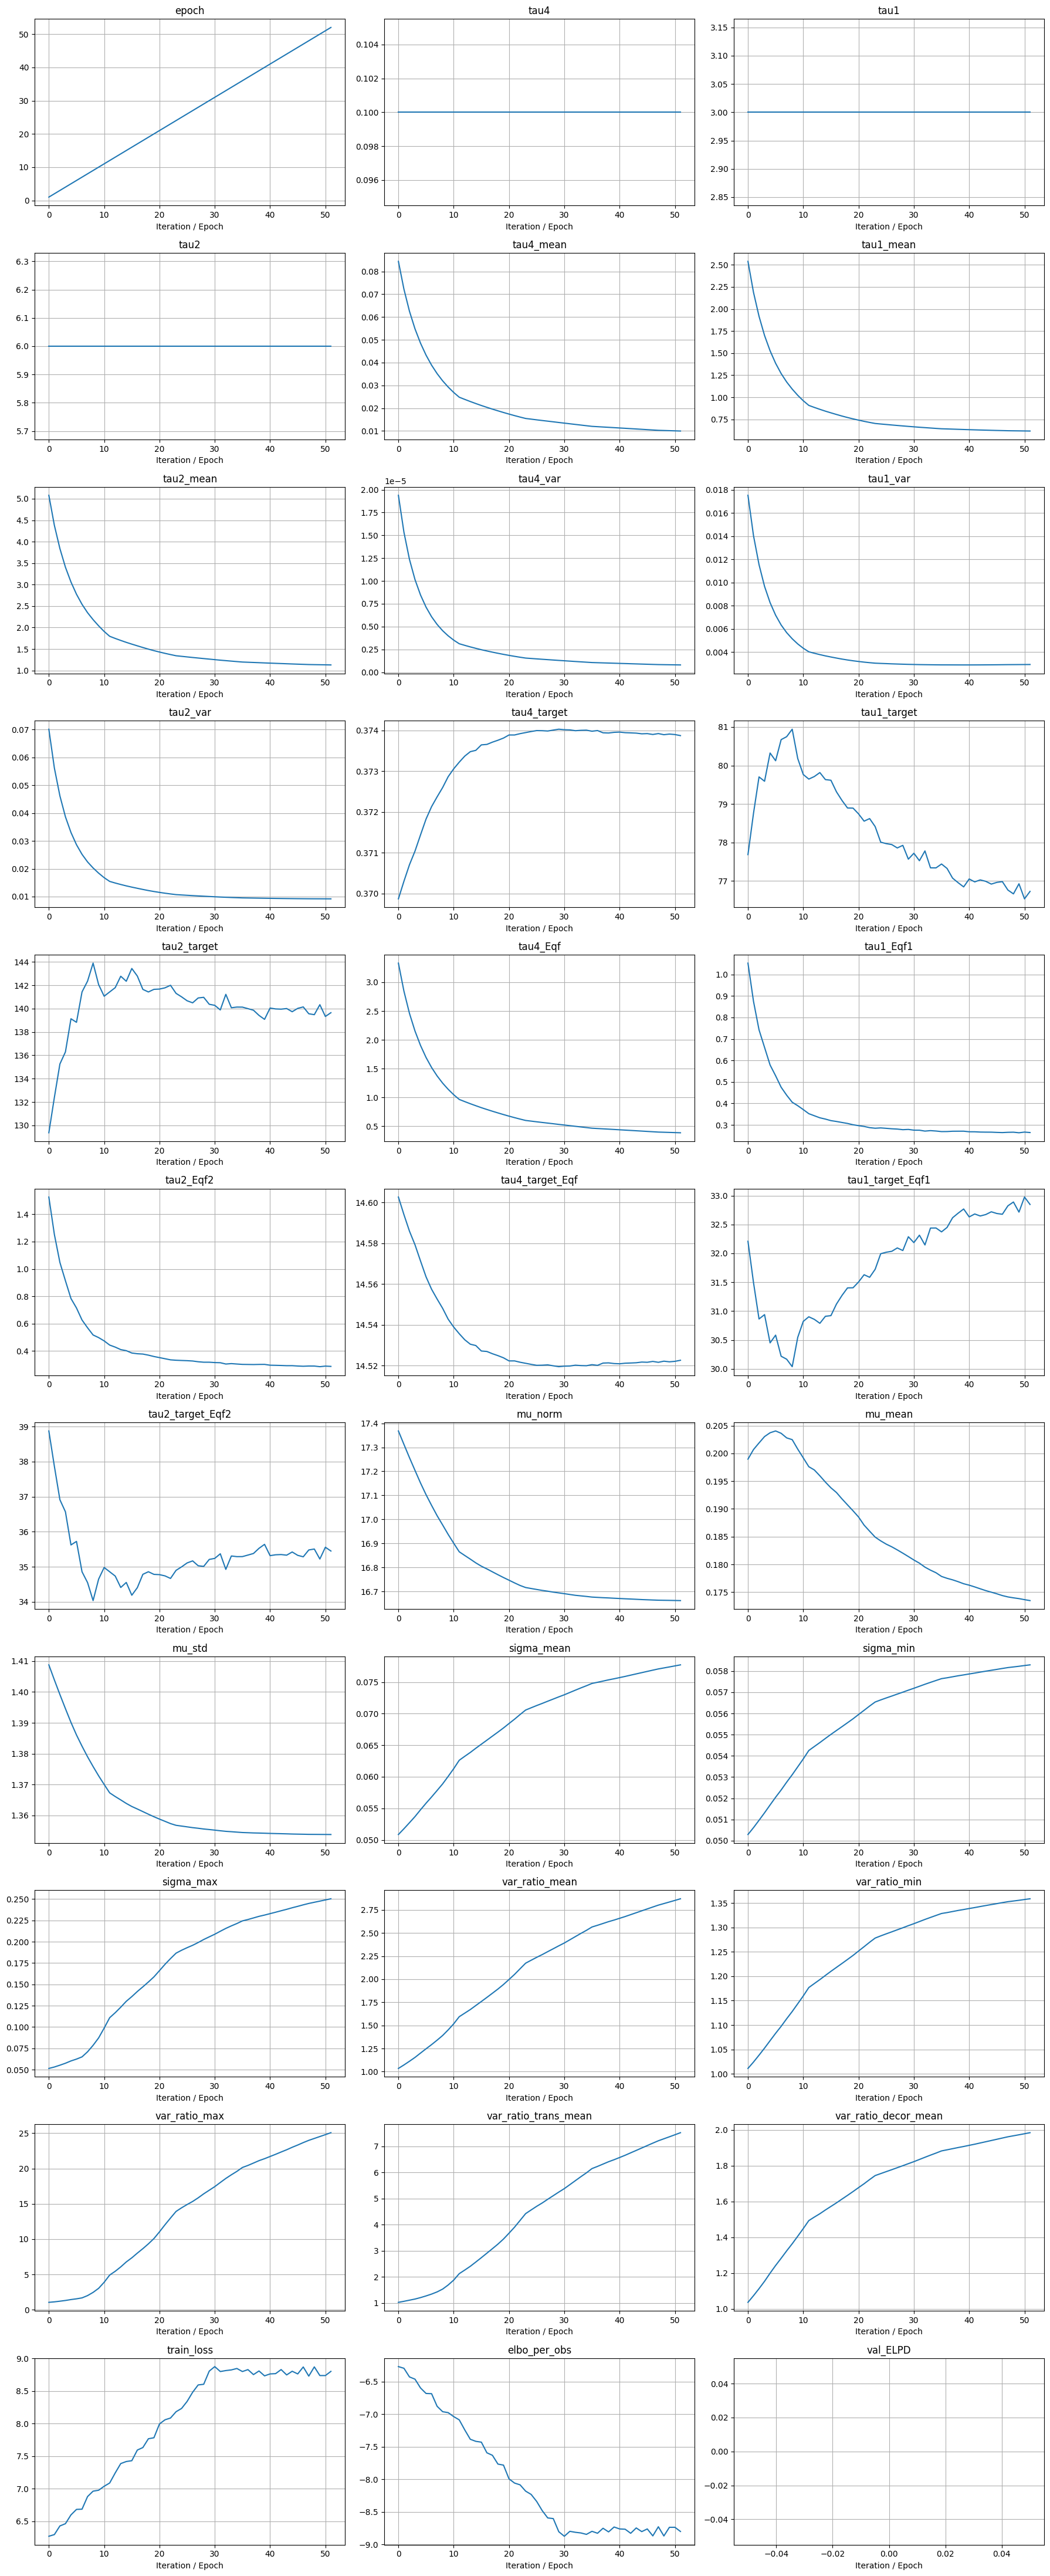

In [11]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
import torch

def build_full_covariance(VI) -> torch.Tensor:
    """
    Construct the full covariance matrix Σ (D x D) implied by the block-diagonal
    structure in VI_Model.

    Σ = blockdiag( Σ_block1, Σ_block2, ..., diag(σ_diag^2) )
    """
    D = VI.mu.numel()
    Sigma = torch.zeros(D, D, device=VI.mu.device)

    # Diagonal part
    if VI.num_diag > 0:
        var_diag = VI.sigma_diag ** 2  # [D_diag]
        Sigma[VI.diag_indices, VI.diag_indices] = var_diag

    # Block parts
    if VI.block_sizes:
        L_blocks = VI._build_L_blocks()
        for idx, L in zip(VI.block_indices, L_blocks):
            Sigma_block = L @ L.T   # [K, K]
            # idx is a 1D index tensor; we need outer indexing
            idx = idx.to(Sigma.device)
            Sigma[idx.unsqueeze(1), idx.unsqueeze(0)] = Sigma_block

    return Sigma



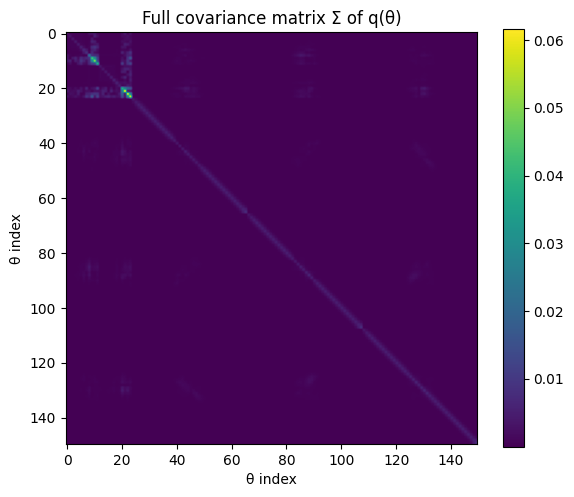

In [ ]:
import matplotlib.pyplot as plt

VI = output["vi_model"]  # from train_bayes
Sigma = build_full_covariance(VI).detach().cpu()

plt.figure(figsize=(6, 5))
plt.imshow(torch.log1p(Sigma.abs()), cmap="viridis")
plt.colorbar()
plt.title("Full covariance matrix Σ of q(θ)")
plt.xlabel("θ index")
plt.ylabel("θ index")
plt.tight_layout()
plt.show()


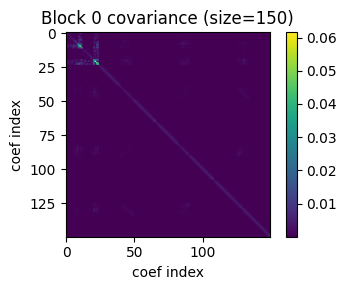

In [ ]:
def plot_blocks_covariance(VI):
    if not VI.block_sizes:
        print("No MV blocks defined in VI_Model.")
        return

    L_blocks = VI._build_L_blocks()
    for b, (idx, L) in enumerate(zip(VI.block_indices, L_blocks)):
        Sigma_b = (L @ L.T).detach().cpu()
        plt.figure(figsize=(4, 3))
        #plt.imshow(Sigma_b, interpolation="nearest")
        plt.imshow(torch.log1p(Sigma_b.abs()), cmap="viridis")
        plt.colorbar()
        plt.title(f"Block {b} covariance (size={idx.numel()})")
        plt.xlabel("coef index")
        plt.ylabel("coef index")
        plt.tight_layout()
        plt.show()

# usage:
plot_blocks_covariance(VI)

In [15]:

VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [ ]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0083
KLD GTM      Train Data:  0.0108
KLD Gaussian Train Data:  0.1165
KLD Copula   Train Data:  -0.0003

KLD BGTM      Test  Data:  0.0129
KLD GTM      Test  Data:  0.0135
KLD Gaussian Test  Data:  0.1128
KLD Copula   Test  Data:  0.0003


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
#synthetic_samples = model.sample(10000)
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

synthetic_samples = VI.predictive_sample(
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    n_samples=10_000,
    S=32,
)

model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 0: valid interval = [-9.999999953674317, 9.999999953674317]
[FIX] var 1: valid interval = [-9.999999953674317, 9.999999953674317]


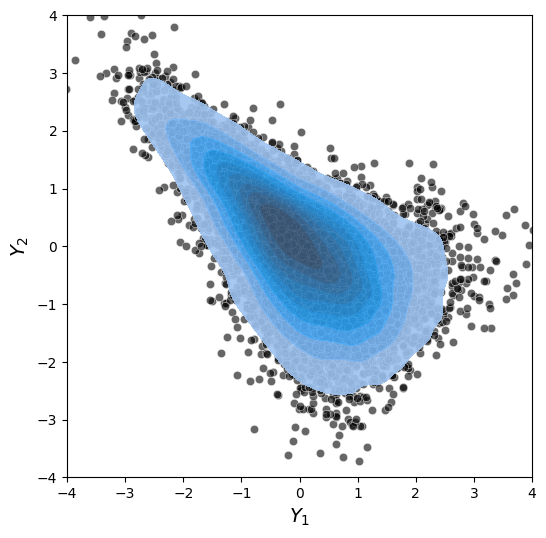

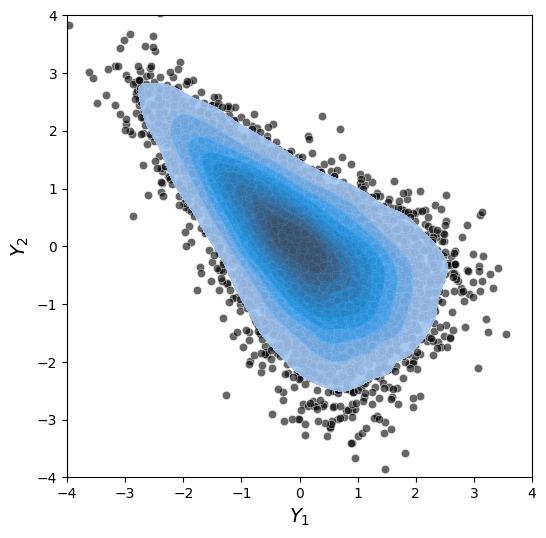

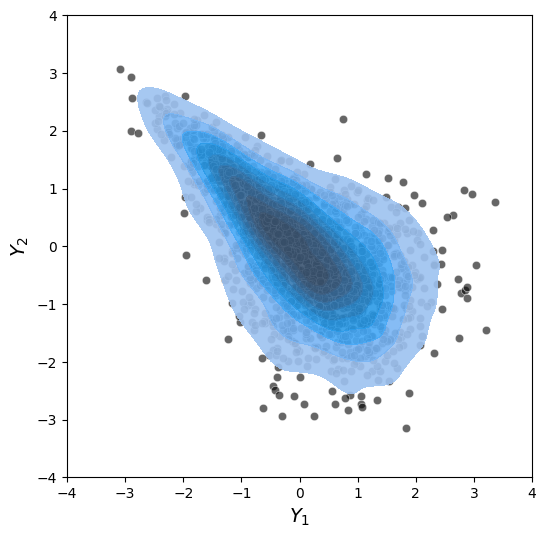

In [19]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


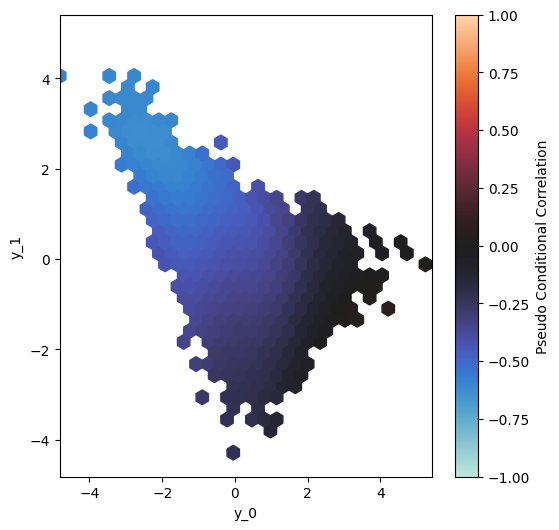

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


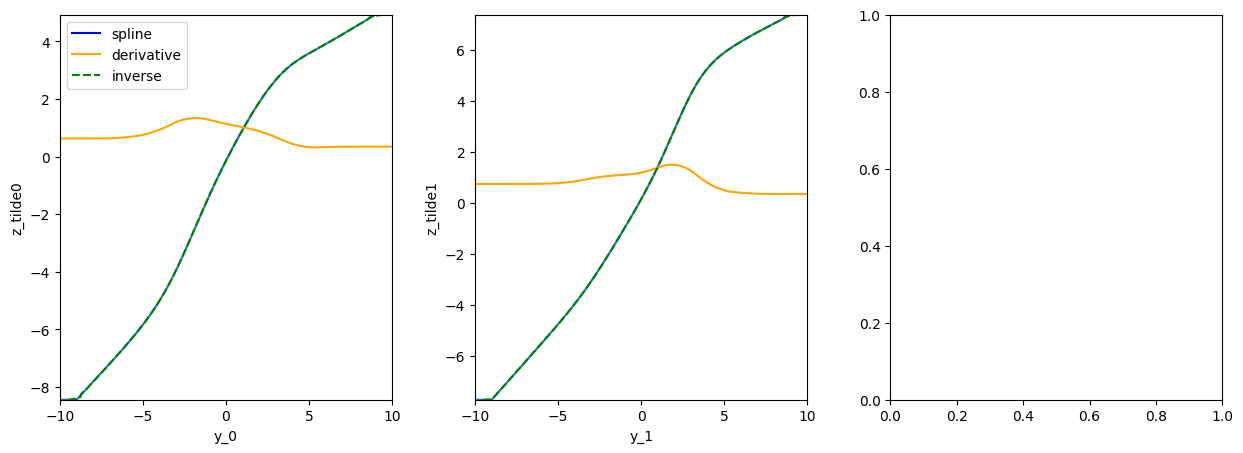

In [22]:
model.plot_splines(layer_type="transformation")

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


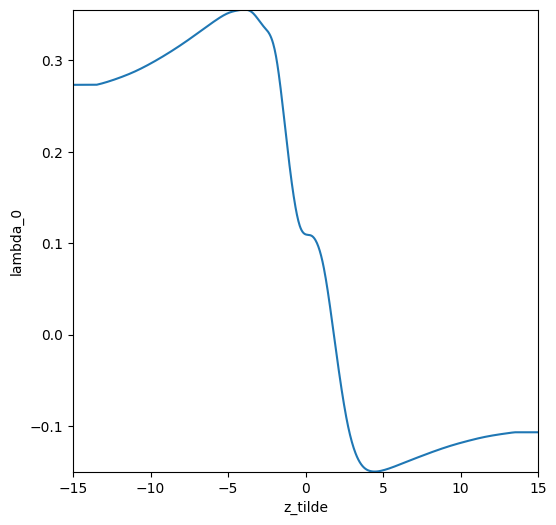

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


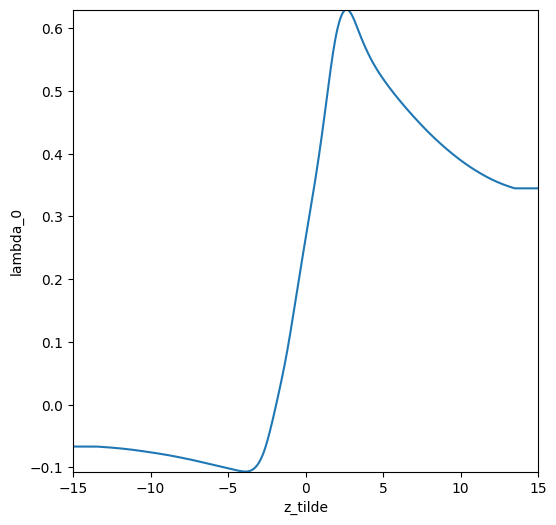

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:284: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


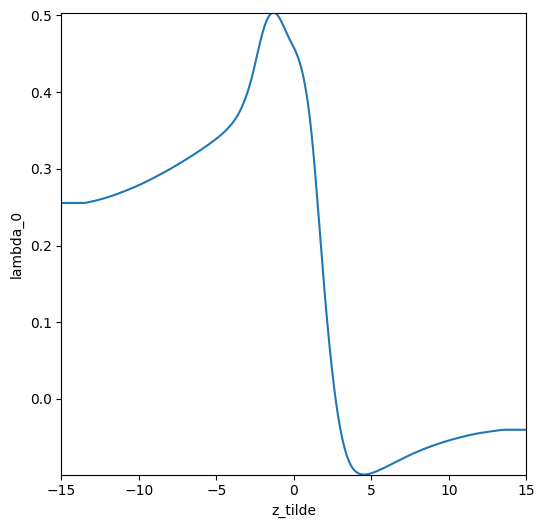

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)